The plan
1. Binary Classification:
- [Basemodel](#scrollTo=Ru-RizLKGFbU&line=1&uniqifier=1)
- [RFC on scaled stances with 3 extra features](#scrollTo=MWmZSwb2GwhW&line=1&uniqifier=1)
- [RFC on scaled stances with 6 extra features](#scrollTo=G_8VoeVA4kv6)
- [RFC on scaled stances with 3 extra features and statics](#scrollTo=XUPH5RyjBXEP)
- [RFC on scaled stances with 6 extra features and statics](#scrollTo=hcySvPsbFqer)
- [RFC model on scaled stances from the right & left foot with 6 extra features each](#scrollTo=aHzN61VULEay&line=1&uniqifier=1)
- [RFC model on scaled stances from the right & left foot with 6 extra features each and basemodels](#scrollTo=FtjB199dOR-m&line=1&uniqifier=1)
- [RFC model on scaled stances from 16 sensor from the right & left foot with 6 extra features each](#scrollTo=GJzuSBzlQ8ES&line=1&uniqifier=1)
- [RFC model on scaled stances from 16 sensor from the right & left foot with the sum of all sensors and with 6 extra features each ](#scrollTo=WunSzzfXco69&line=1&uniqifier=1)
- [RFC model on scaled stances from 16 sensor from the right & left foot and the sum of all sensors and with 6 extra features each foot and the statics from base models](#scrollTo=Pbf7jqHRdG2b&line=1&uniqifier=1)

1. Multiclass Classification - Severity Detection
- [Baselline Model](#scrollTo=RFVESVzhj2qv&line=1&uniqifier=1)
- [RFC model on scaled stances from 16 sensor from the right & left foot with the sum of all sensors and with 6 extra features each](#scrollTo=ihK6ZuxMlqaK&line=1&uniqifier=1)
- [RFC model on scaled stances from 16 sensor from the right & left foot and the sum of all sensors and with 6 extra features each foot and the statics from base models](#scrollTo=hNWcAO2OpvTo&line=1&uniqifier=1)




## Importing libraries

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import os

import sys

from tqdm.auto import tqdm

import shutil

from itertools import groupby

import matplotlib.pyplot as plt

from statistics import mean

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy import signal

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import GridSearchCV

In [26]:
sys.path.insert(0,"/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester")

## Importing my Classes :)

In [21]:
parquet_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Data/parquet_files/"
models_path = "/content/drive/MyDrive/ITMO-Master's/Thesis/3rd_semester/Models/"

In [27]:
# Data Class
import DataClass 
from DataClass import Data
# Random Forest Classifier Class
import RFClassifier
from RFClassifier import RFClassifier

In [28]:
# read prepared data
data = Data( 0, "", "",parquet_path)

In [29]:
data.scaled_stances_statics_df=data.scaled_stances_statics_df.rename({'L4_kurtosis':'L4_Kurtosis','L5_kurtosis':'L5_Kurtosis'},axis=1)

## RFC (Binary Classification)

In [37]:
def cross_val(rfc, X_train, y_train,X_test,y_test, n_folds,average):
  # Use cross validation to train and evaluate the model
  scores = cross_val_score(rfc, X_train, y_train, cv=n_folds)

  # Print the mean and standard deviation of the cross validation scores
  print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

  # Train the model on the full training set
  rfc.fit(X_train, y_train)

  # Test the model on the separate test data
  y_pred = rfc.predict(X_test)

  # Calculate the accuracy score of the model on the test data
  accuracy = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred,average=average)
  rec = recall_score(y_test, y_pred,average=average)
  f1 = f1_score(y_test, y_pred,average=average)
  # Print the accuracy score of the model on the test data
  print("Test Accuracy:", accuracy)
  print("Test Prec:", prec)
  print("Test Recall:", rec)
  print("Test F1:", f1)

In [38]:
def cross_val_multiple_scores(rfc,X,y,cv,average):
  scoring = {'acc': make_scorer(accuracy_score),
            'prec': make_scorer(precision_score,average=average),
            'rec': make_scorer(recall_score,average=average),
            'f1': make_scorer(f1_score,average=average)}
  scores = cross_validate (rfc, X, y, scoring=scoring,
                          cv=cv, return_train_score=True)
  print(f"Test Accuracy: {scores['test_acc'].mean()} +/- {scores['test_acc'].std() *2 }")
  print(f"Test Prec: {scores['test_prec'].mean()} +/- {scores['test_prec'].std() *2 }")
  print(f"Test Recall: {scores['test_rec'].mean()} +/- {scores['test_rec'].std() *2 }")
  print(f"Test F1: {scores['test_f1'].mean()} +/- {scores['test_f1'].std() *2 }")
  return [scores['test_acc'].mean(), scores['test_prec'].mean(), scores['test_rec'].mean(), scores['test_f1'].mean()]


In [ ]:
cross_scores = {'acc':[],"prec":[],"rec":[],"f1":[]}

In [ ]:
cross_scores_search = {'acc':[],"prec":[],"rec":[],"f1":[]}

In [ ]:
cross_scores_search_multi = {'acc':[],"prec":[],"rec":[],"f1":[]}

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [10, 50, 100, 200]
    #,'max_depth': [5, 10, 20],
    #'min_samples_split': [2, 5, 10],
    #'n_jobs' : [-1,1,2,4]
}
def cross_val_search(X_train, y_train,X_test, y_test, average='binary',param_grid=param_grid):
    # Create a random forest classifier
    rf = RandomForestClassifier()

    # Use cross validation to find the best parameters
    grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Train the model on the entire training set with the best parameters
    best_rf = RandomForestClassifier(**grid_search.best_params_)
    best_rf.fit(X_train, y_train)

    # Predict on the test set and evaluate performance
    y_pred = best_rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average=average)
    rec = recall_score(y_test, y_pred,average=average)
    f1 = f1_score(y_test, y_pred,average=average)
    # Print the accuracy score of the model on the test data
    print("Test Accuracy:", accuracy)
    print("Test Prec:", prec)
    print("Test Recall:", rec)
    print("Test F1:", f1)
    print(grid_search.best_params_)
    return [accuracy,prec,rec,f1,y_pred]

### Baseline model

In [ ]:
# the data used 
data.raw_statics_df.shape

(304, 129)

In [ ]:
# splitting the data into train and test data
y = data.raw_statics_df['y']
X = data.raw_statics_df.drop(columns=['ID', 'level', 'y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=64)

In [ ]:
# Checking which RFC will work the best
rfc = RFClassifier(models_path,200,2)
ccs=rfc.multiple_training([5, 10, 20, 40, 100, 200],2,X_train, np.ravel(y_train), X_test, y_test)

Estimator = 5
Accuracy: 0.8553, Precision: 0.8462, Recall: 0.9821, F1: 0.9091
Estimator = 10
Accuracy: 0.8553, Precision: 0.8571, Recall: 0.9643, F1: 0.9076
Estimator = 20
Accuracy: 0.8289, Precision: 0.8525, Recall: 0.9286, F1: 0.8889
Estimator = 40
Accuracy: 0.8816, Precision: 0.8852, Recall: 0.9643, F1: 0.9231
Estimator = 100
Accuracy: 0.9211, Precision: 0.9167, Recall: 0.9821, F1: 0.9483
Estimator = 200
Accuracy: 0.9079, Precision: 0.9153, Recall: 0.9643, F1: 0.9391


In [ ]:
# recreating the best model to be saved
rfc_100 = RFClassifier(models_path,100,2)
rfc_100.taining(X_train,np.ravel(y_train))
y_pred=rfc_100.predict(X_test)
scores=rfc_100.scores(y_test, y_pred)
rfc_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
#rfc_100.save_model("RFC_raw_statics_100")

Accuracy: 0.9210526315789473
Precision: 0.9166666666666666
Recall: 0.9821428571428571
F1: 0.9482758620689654


#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,X,y,10)

Test Accuracy: 0.8329032258064517 +/- 0.18099863011780162
Test Prec: 0.8715562236364335 +/- 0.1615824318012923
Test Recall: 0.9084415584415584 +/- 0.19008273018152513
Test F1: 0.8844408830463187 +/- 0.122726873000547


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
#rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
#cross_val(rfc, X_train, y_train, X_test, y_test,10,'binary')

Cross Validation Accuracy: 0.88 (+/- 0.13)
Test Accuracy: 0.9210526315789473
Test Prec: 0.9166666666666666
Test Recall: 0.9821428571428571
Test F1: 0.9482758620689654


In [ ]:
# cross_val_search(X_train, y_train,X_test, y_test)

Test Accuracy: 0.8947368421052632
Test Prec: 0.9137931034482759
Test Recall: 0.9464285714285714
Test F1: 0.9298245614035087


In [ ]:
scores = cross_val_search(X_train, y_train,X_test, y_test)

Test Accuracy: 0.881578947368421
Test Prec: 0.8983050847457628
Test Recall: 0.9464285714285714
Test F1: 0.9217391304347826
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

In [ ]:
cross_scores_search

{'acc': [0.881578947368421],
 'prec': [0.8983050847457628],
 'rec': [0.9464285714285714],
 'f1': [0.9217391304347826]}

### Scaled stances wih fwhm from the sum of forces from the right foot with 3 extra features
 'r_swings_time','r_max_peak','r_total_fwhm'

In [ ]:
# input data and label data
df_1 = data.scaled_stances_statics_df[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm']]
y_1 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
df_1 = data.return_array_df(df_1,'r_interp',['r_swings_time','r_max_peak','r_total_fwhm'])
# splitting the data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, y_1, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_1 = RFClassifier(models_path,200,2)
ccs=rfc_1.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_1, y_train_1, X_test_1,  y_test_1 )

Estimator = 5
Accuracy: 0.9034, Precision: 0.9103, Recall: 0.9515, F1: 0.9304
Estimator = 10
Accuracy: 0.9223, Precision: 0.9313, Recall: 0.9560, F1: 0.9435
Estimator = 20
Accuracy: 0.9313, Precision: 0.9314, Recall: 0.9703, F1: 0.9504
Estimator = 40
Accuracy: 0.9390, Precision: 0.9362, Recall: 0.9767, F1: 0.9560
Estimator = 100
Accuracy: 0.9418, Precision: 0.9370, Recall: 0.9803, F1: 0.9581
Estimator = 200
Accuracy: 0.9414, Precision: 0.9356, Recall: 0.9812, F1: 0.9579


In [ ]:
# recreating the best model to be saved
rfc_1_100 = RFClassifier(models_path,100,2)
rfc_1_100.tain(X_train_1,np.ravel(y_train_1))
y_pred=rfc_1_100.predict(X_test_1)
scores=rfc_1_100.scores(y_test_1, y_pred)
rfc_1_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model

rfc_1_100.save_model("RFC_scaled_stances_100")

#### Cross Validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
cross_val(rfc, X_train_1, np.ravel(y_train_1),X_test_1, np.ravel(y_test_1), 5,'binary')

Cross Validation Accuracy: 0.93 (+/- 0.00)
Test Accuracy: 0.9418477068246653
Test Prec: 0.9369592088998764
Test Recall: 0.9802780472033624
Test F1: 0.9581292463264339


#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_1,np.ravel(y_1),10)

Test Accuracy: 0.7092206065561826 +/- 0.17566369642368793
Test Prec: 0.7708475545817676 +/- 0.08723675678465656
Test Recall: 0.817554907926341 +/- 0.24989414996962442
Test F1: 0.7896608200522317 +/- 0.15303472197071974


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_1, np.ravel(y_train_1),X_test_1, np.ravel(y_test_1))

Test Accuracy: 0.9403116085143735
Test Prec: 0.9338665026145802
Test Recall: 0.9815712900096993
Test F1: 0.957124842370744
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

In [ ]:
cross_scores_search

### Scaled stances wih fwhm from the sum of forces from the right foot with 6 extra features 
'r_swings_time','r_max_peak','r_total_fwhm', 'r_strides_time','r_peaks_toe','r_peaks_heel'

In [ ]:
# input data and label data
df_2 = data.scaled_stances_statics_df[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel']]
y_2 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
df_2 = data.return_array_df(df_2,'r_interp',['r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel'])
# splitting the data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, y_2, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_2 = RFClassifier(models_path,200,2)
ccs=rfc_2.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_2, y_train_2, X_test_2,  y_test_2 )

Estimator = 5
Accuracy: 0.9276, Precision: 0.9308, Recall: 0.9651, F1: 0.9476
Estimator = 10
Accuracy: 0.9394, Precision: 0.9450, Recall: 0.9670, F1: 0.9559
Estimator = 20
Accuracy: 0.9497, Precision: 0.9475, Recall: 0.9803, F1: 0.9636
Estimator = 40
Accuracy: 0.9502, Precision: 0.9456, Recall: 0.9832, F1: 0.9640
Estimator = 100
Accuracy: 0.9537, Precision: 0.9461, Recall: 0.9880, F1: 0.9666
Estimator = 200
Accuracy: 0.9535, Precision: 0.9453, Recall: 0.9887, F1: 0.9665


In [ ]:
# recreating the best model to be saved
rfc_2_100 = RFClassifier(models_path,100,2)
rfc_2_100.tain(X_train_2,y_train_2)
y_pred_2=rfc_2_100.predict(X_test_2)
scores=rfc_2_100.scores(y_test_2, y_pred_2)
# rfc_2_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
rfc_2_100.save_model("RFC_scaled_stances_6_features_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_2,np.ravel(y_2),10)

Test Accuracy: 0.7341262367131055 +/- 0.13882399311491567
Test Prec: 0.7896537963710886 +/- 0.09462116003069211
Test Recall: 0.837005476381105 +/- 0.1657436612307684
Test F1: 0.8105927317741422 +/- 0.10424255636119675


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_2, np.ravel(y_train_2),X_test_2, np.ravel(y_test_2))

Test Accuracy: 0.9532587228439763
Test Prec: 0.9452690166975881
Test Recall: 0.988360814742968
Test F1: 0.96633475580844
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the sum of forces from the right foot with 3 extra features and statics
 'r_swings_time','r_max_peak','r_total_fwhm' and statics from basemodel


In [ ]:
# input data and label data
colnames_3=['r_interp','r_swings_time','r_max_peak','r_total_fwhm']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
    for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
      colnames_3.append( col +'_' +  x)

In [ ]:
df_3 = data.scaled_stances_statics_df[colnames_3]
y_3 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
colnames_3.remove("r_interp")
df_3 = data.return_array_df(df_3,'r_interp',colnames_3)
# splitting the data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_3, y_3, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_3 = RFClassifier(models_path,200,2)
ccs_3 = rfc_3.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_3, y_train_3,X_test_3, y_test_3)

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
# recreating the best model to be saved
rfc_3_100 = RFClassifier(models_path,100,2)
rfc_3_100.tain(X_train_3,y_train_3)
y_pred_3=rfc_3_100.predict(X_test_3)
scores=rfc_3_100.scores(y_test_3, y_pred_3)
# rfc_2_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
rfc_3_100.save_model("RFC_scaled_stances_3_features_statics_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_3,np.ravel(y_3),10)

Test Accuracy: 0.8435931472049123 +/- 0.1933692167873902
Test Prec: 0.9007365652632668 +/- 0.15562021672279555
Test Recall: 0.8779962209767815 +/- 0.26436099638466154
Test F1: 0.8814544636916801 +/- 0.160748090890438


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_3, np.ravel(y_train_3),X_test_3, np.ravel(y_test_3))

Test Accuracy: 1.0
Test Prec: 1.0
Test Recall: 1.0
Test F1: 1.0
{'n_estimators': 10}


In [ ]:
scores 

[1.0, 1.0, 1.0, 1.0]

In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the sum of forces from the right foot with 6 extra features and statics
 'r_swings_time','r_max_peak','r_total_fwhm' and statics from basemodel
 

In [ ]:
# input data and label data
colnames_4=['r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
    for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
      colnames_4.append( col +'_' +  x)

In [ ]:
df_4 = data.scaled_stances_statics_df[colnames_4]
y_4 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
colnames_4.remove("r_interp")
df_4 = data.return_array_df(df_4,'r_interp',colnames_4)
# splitting the data
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(df_4, y_4, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_4 = RFClassifier(models_path,200,2)
ccs_4 = rfc_4.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_4, y_train_4,X_test_4, y_test_4)

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
# recreating the best model to be saved
rfc_4_100 = RFClassifier(models_path,100,2)
rfc_4_100.tain(X_train_4,y_train_4)
y_pred_4=rfc_4_100.predict(X_test_4)
scores=rfc_4_100.scores(y_test_4, y_pred_4)
# rfc_2_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
rfc_4_100.save_model("RFC_scaled_stances_6_features_statics_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_4,np.ravel(y_4),10)

Test Accuracy: 0.8144097587058401 +/- 0.22693298314259103
Test Prec: 0.8837840869871052 +/- 0.16148378284333206
Test Recall: 0.8480555964771817 +/- 0.3129019935204911
Test F1: 0.8563066549282334 +/- 0.195940573406736


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

In [ ]:
cross_scores

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_4, np.ravel(y_train_4),X_test_4, np.ravel(y_test_4))

Test Accuracy: 1.0
Test Prec: 1.0
Test Recall: 1.0
Test F1: 1.0
{'n_estimators': 10}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the sum of forces from the right & left foot with 6 extra features each

In [ ]:
# input data and label data
df_5 = data.scaled_stances_statics_df[[ 'r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_interp','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']]
y_5 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
df_5 = data.return_array_df_mul_lists(df_5,['r_interp','l_interp'],['r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel'])
# splitting the data
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(df_5, y_5, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_5 = RFClassifier(models_path,200,2)
ccs_5=rfc_5.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_5, y_train_5, X_test_5,  y_test_5 )

Estimator = 5
Accuracy: 0.9339, Precision: 0.9382, Recall: 0.9664, F1: 0.9521
Estimator = 10
Accuracy: 0.9513, Precision: 0.9559, Recall: 0.9732, F1: 0.9644
Estimator = 20
Accuracy: 0.9587, Precision: 0.9526, Recall: 0.9884, F1: 0.9702
Estimator = 40
Accuracy: 0.9590, Precision: 0.9512, Recall: 0.9903, F1: 0.9704
Estimator = 100
Accuracy: 0.9614, Precision: 0.9522, Recall: 0.9929, F1: 0.9721
Estimator = 200
Accuracy: 0.9607, Precision: 0.9511, Recall: 0.9932, F1: 0.9717


In [ ]:
# recreating the best model to be saved
rfc_5_100 = RFClassifier(models_path,100,2)
rfc_5_100.tain(X_train_5,y_train_5)
y_pred_5=rfc_5_100.predict(X_test_5)
scores_5=rfc_5_100.scores(y_test_5, y_pred_5)
# rfc_2_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
rfc_5_100.save_model("RFC_both_feet_scaled_stances_6_features_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_5,np.ravel(y_5),10)
scores

Test Accuracy: 0.7529455915479304 +/- 0.11966578394804564
Test Prec: 0.7954697284043715 +/- 0.07689264610315737
Test Recall: 0.8619057165732587 +/- 0.1447826824749647
Test F1: 0.8260518473691985 +/- 0.09158822644693967


[0.7529455915479304,
 0.7954697284043715,
 0.8619057165732587,
 0.8260518473691985]

In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_5, np.ravel(y_train_5),X_test_5, np.ravel(y_test_5))

Test Accuracy: 0.9609392143954356
Test Prec: 0.9502625888168057
Test Recall: 0.9945037180730683
Test F1: 0.9718799368088468
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the sum of forces from the right & left foot with 6 extra features each and statics from base model

In [ ]:
# input data and label data
colnames_6=['r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_interp','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
    for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
      colnames_6.append( col +'_' +  x)

In [ ]:
df_6 = data.scaled_stances_statics_df[colnames_6]
y_6 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
colnames_6.remove("r_interp")
colnames_6.remove("l_interp")
df_6 = data.return_array_df_mul_lists(df_6,['r_interp','l_interp'],colnames_6)
# splitting the data
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(df_6, y_6, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_6 = RFClassifier(models_path,200,2)
ccs_6=rfc_6.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_6, y_train_6, X_test_6,  y_test_6 )

Estimator = 5
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 10
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
# recreating the best model to be saved
rfc_6_100 = RFClassifier(models_path,100,2)
rfc_6_100.tain(X_train_6,y_train_6)
y_pred_6=rfc_6_100.predict(X_test_6)
scores_6=rfc_6_100.scores(y_test_6, y_pred_6)
# rfc_2_100.print_scores(scores[0],scores[1],scores[2],scores[3])
# saving the best model
rfc_6_100.save_model("RFC_both_feet_scaled_stances_6_features_statics_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_6,np.ravel(y_6),10)

Test Accuracy: 0.8195589590986738 +/- 0.20824244481724918
Test Prec: 0.8870742902846398 +/- 0.16116494371081522
Test Recall: 0.8573352762209769 +/- 0.31103248607383954
Test F1: 0.8612098873892753 +/- 0.18525914268461136


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_6, np.ravel(y_train_6),X_test_6, np.ravel(y_test_6))

In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the forces of 16 sensor from the right & left foot with 6 extra features each

In [ ]:
colnames_7=['r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_7.append( col +'_' +  x)

In [ ]:
col_lists_7=[]
for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_7.append( col +'_' +  x)

In [ ]:
df_7 = data.scaled_stances_statics_df[colnames_7]
y_7 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
for col in col_lists_7:
  colnames_7.remove(col)
df_7 = data.return_array_df_mul_lists(df_7,col_lists_7,colnames_7)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
df_7[np.isnan(df_7)] = 0
# splitting the data
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(df_7, y_7, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_7 = RFClassifier(models_path,200,2)
ccs_7=rfc_7.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_7, y_train_7, X_test_7,  y_test_7 )

Estimator = 5
Accuracy: 0.9511, Precision: 0.9484, Recall: 0.9812, F1: 0.9646
Estimator = 10
Accuracy: 0.9581, Precision: 0.9577, Recall: 0.9816, F1: 0.9695
Estimator = 20
Accuracy: 0.9636, Precision: 0.9549, Recall: 0.9932, F1: 0.9737
Estimator = 40
Accuracy: 0.9629, Precision: 0.9535, Recall: 0.9939, F1: 0.9732
Estimator = 100
Accuracy: 0.9605, Precision: 0.9497, Recall: 0.9945, F1: 0.9716
Estimator = 200
Accuracy: 0.9603, Precision: 0.9486, Recall: 0.9955, F1: 0.9714


In [ ]:
# recreating the best model to be saved
rfc_7_20 = RFClassifier(models_path,20,2)
rfc_7_20.tain(X_train_7,y_train_7)
y_pred_7=rfc_7_20.predict(X_test_7)
scores_7=rfc_7_20.scores(y_test_7, y_pred_7)
# rfc_7_20.print_scores(scores_7[0],scores_7[1],scores_7[2],scores_7[3])
# saving the best model
rfc_7_20.save_model("RFC_both_feet_16_sensors_6_features_20")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_7,np.ravel(y_7),10)

Test Accuracy: 0.7514052661654081 +/- 0.07708919428915072
Test Prec: 0.7715137532230669 +/- 0.06955956836408303
Test Recall: 0.909138318654924 +/- 0.07225028575957067
Test F1: 0.8338509203033899 +/- 0.04772044590080145


[0.7514052661654081, 0.7715137532230669, 0.909138318654924, 0.8338509203033899]

In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_7, np.ravel(y_train_7),X_test_7, np.ravel(y_test_7))

Test Accuracy: 0.9622558700899715
Test Prec: 0.9506325208269053
Test Recall: 0.9961202715809894
Test F1: 0.972844963688033
{'n_estimators': 50}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the forces of 16 sensor from the right & left foot and the sum of all sensors and the with 6 extra features each 

In [ ]:
colnames_9=['r_interp','l_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_9.append( col +'_' +  x)

In [ ]:
col_lists_9=[]
for col in ["l","r","L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_9.append( col +'_' +  x)

In [ ]:
df_9 = data.scaled_stances_statics_df[colnames_9]
y_9 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
for col in col_lists_9:
  colnames_9.remove(col)
df_9 = data.return_array_df_mul_lists(df_9,col_lists_9,colnames_9)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
df_9[np.isnan(df_9)] = 0
# splitting the data
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(df_9, y_9, random_state=42)

In [ ]:
# Checking which RFC will work the best
rfc_9 = RFClassifier(models_path,200,2)
ccs_9=rfc_9.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_9, y_train_9, X_test_9,  y_test_9 )

Estimator = 5
Accuracy: 0.9434, Precision: 0.9423, Recall: 0.9764, F1: 0.9590
Estimator = 10
Accuracy: 0.9596, Precision: 0.9593, Recall: 0.9822, F1: 0.9706
Estimator = 20
Accuracy: 0.9631, Precision: 0.9529, Recall: 0.9948, F1: 0.9734
Estimator = 40
Accuracy: 0.9636, Precision: 0.9530, Recall: 0.9955, F1: 0.9738
Estimator = 100
Accuracy: 0.9645, Precision: 0.9533, Recall: 0.9964, F1: 0.9744
Estimator = 200
Accuracy: 0.9642, Precision: 0.9524, Recall: 0.9971, F1: 0.9743


In [ ]:
# recreating the best model to be saved
rfc_9_100 = RFClassifier(models_path,100,2)
rfc_9_100.tain(X_train_9,y_train_9)
y_pred_9=rfc_9_100.predict(X_test_9)
scores_9=rfc_9_100.scores(y_test_9, y_pred_9)
# rfc_7_20.print_scores(scores_7[0],scores_7[1],scores_7[2],scores_7[3])
# saving the best model
rfc_9_100.save_model("RFC_both_feet_16_sensors_sumsensors_6_features_100")

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_9,np.ravel(y_9),10)

Test Accuracy: 0.7387854786352938 +/- 0.08674980289873299
Test Prec: 0.7643007967128737 +/- 0.07440294815864308
Test Recall: 0.8987320416333068 +/- 0.07698353662601945
Test F1: 0.8252313504512309 +/- 0.05504420631390414


In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_9, np.ravel(y_train_9),X_test_9, np.ravel(y_test_9))

Test Accuracy: 0.9659863945578231
Test Prec: 0.953955500618047
Test Recall: 0.9980601357904947
Test F1: 0.975509559172065
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

### Scaled stances wih fwhm from the forces of 16 sensor from the right & left foot and the sum of all sensors and the with 6 extra features each and the statics from base models

In [ ]:
colnames_8=['r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_interp','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_8.append( col +'_' +  x)

for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
    for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness", "Kurtosis"]:
      colnames_8.append( col +'_' +  x)

col_lists_8=['r_interp','l_interp']
for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_8.append( col +'_' +  x)

df_8 = data.scaled_stances_statics_df[colnames_8]
y_8 = data.scaled_stances_statics_df[[ 'y']]
# reformatting
for col in col_lists_8:
  colnames_8.remove(col)
df_8 = data.return_array_df_mul_lists(df_8,col_lists_8,colnames_8)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
df_8[np.isnan(df_8)] = 0
# splitting the data
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(df_8, y_8, random_state=42)


In [ ]:
# Checking which RFC will work the best
rfc_8 = RFClassifier(models_path,200,2)
ccs_8=rfc_8.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_8, y_train_8, X_test_8,  y_test_8 )

Estimator = 5
Accuracy: 0.9974, Precision: 0.9974, Recall: 0.9987, F1: 0.9981
Estimator = 10
Accuracy: 0.9996, Precision: 1.0000, Recall: 0.9994, F1: 0.9997
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [ ]:
# recreating the best model to be saved
rfc_8_100 = RFClassifier(models_path,100,2)
rfc_8_100.taining(X_train_8,y_train_8)
y_pred_8=rfc_8_100.predict(X_test_8)
scores_8=rfc_8_100.scores(y_test_8, y_pred_8)
# saving the best model
#rfc_8_100.save_model("RFC_both_feet_16_sensors_sumsensors_6_features_100") 

#### Cross validation
Measures from validation while training with cross-validation

In [ ]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
scores = cross_val_multiple_scores(rfc,df_8,np.ravel(y_8),10)
scores

Test Accuracy: 0.8179675123272396 +/- 0.19742844919227948
Test Prec: 0.866645504697173 +/- 0.1584540154446422
Test Recall: 0.87847160928743 +/- 0.27591919463757125
Test F1: 0.8646461640136565 +/- 0.17142318886467148


[0.8179675123272396, 0.866645504697173, 0.87847160928743, 0.8646461640136565]

In [ ]:
cross_scores['acc'].append(scores[0])
cross_scores['prec'].append(scores[1])
cross_scores['rec'].append(scores[2])
cross_scores['f1'].append(scores[3])

#### Cross validation
Search via cross validation then testing

In [ ]:
scores = cross_val_search(X_train_8, np.ravel(y_train_8),X_test_8, np.ravel(y_test_8))

Test Accuracy: 1.0
Test Prec: 1.0
Test Recall: 1.0
Test F1: 1.0
{'n_estimators': 200}


In [ ]:
cross_scores_search['acc'].append(scores[0])
cross_scores_search['prec'].append(scores[1])
cross_scores_search['rec'].append(scores[2])
cross_scores_search['f1'].append(scores[3])

## Plot of measures (RFC models)

In [ ]:
labels = ['Baseline model',\
          'Accum signal from a foot <br> & features',\
          'Accum signal from 1 foot <br> & more features',\
          'Acc signal from 2 feet & <br> features',\
          'Multidim signals & features',\
          'Multidim signals & Accum <br> signal & features',\
          'Multidim signals & Accum <br> signal & features & BLM statics']

In [ ]:
df = pd.DataFrame({ 'Label' : labels,\
                   'Accuracy' :cross_scores_search['acc'],
                   'Precision': cross_scores_search['prec'],
                   'Recall':cross_scores_search['rec'],
                   'F1':cross_scores_search['f1']})

In [ ]:
df

,Label,Accuracy,Precision,Recall,F1
0,Baseline model,0.881579,0.898305,0.946429,0.921739
1,Accum signal from a foot <br> & features,0.940312,0.933867,0.981571,0.957125
2,Accum signal from 1 foot <br> & more features,0.953259,0.945269,0.988361,0.966335
3,Acc signal from 2 feet & <br> features,0.960939,0.950263,0.994504,0.971880
4,Multidim signals & features,0.962256,0.950633,0.996120,0.972845
5,Multidim signals & Accum <br> signal & features,0.965986,0.953956,0.998060,0.975510
6,Multidim signals & Accum <br> signal & feature...,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.to_parquet(parquet_path+'rfc_binary_metrics.gzip')

In [ ]:
pd.options.plotting.backend = "plotly"

In [ ]:
df.plot(x='Label', y=df.columns[1:],
        labels={
                     "Label": "Input Data",
                     "variable": "Metric"
                 },
                title="Binary Classification models")

plot of metrics with cross validation


In [13]:
acc = [0.8329, 0.7092,0.7341,0.7529,0.7514,0.7388,0.8180]
prec=[0.8716, 0.7708, 0.7896, 0.7955,0.7715,0.7643,0.8667]
rec=[0.9084,0.8176,0.8370,0.8169,0.9091,0.8988,0.8785]
f1=[0.8844,0.7879,0.8105,0.8260,0.8338,0.8252,0.8646]

In [18]:
labels = ['Baseline model',\
          'Accum signal from a <br> foot & features',\
          'Accum signal from 1 <br> foot & more features',\
          'Acc signal from 2 <br> feet & features',\
          'Multidim signals & features',\
          'Multidim signals & Accum <br> signal & features',\
          'Multidim signals & Accum <br> signal & features &<br> BLM statics']

In [19]:
df = pd.DataFrame({ 'Label' : labels,\
                   'Accuracy' :acc,
                   'Precision':prec,
                   'Recall':rec,
                   'F1':f1})

In [7]:
pd.options.plotting.backend = "plotly"

In [20]:
df.plot(x='Label', y=df.columns[1:],
        labels={
                     "Label": "Input Data",
                     "variable": "Metric"
                 },
                title="Random Forest Classifier for Binary Classification models")

## RFC (Multiclass Classification)

### Baseline model

In [31]:
min_cols=[]
for col in data.cols_names[1:]:
  colname = col +'_Min'
  min_cols.append(colname)

In [32]:
min_cols= np.append( min_cols, ['ID','y','level'])

In [33]:
# splitting the data into train and test data
y = data.raw_statics_df['level']
X = data.raw_statics_df.drop(columns=min_cols, axis=1)

In [34]:
set(y)

{0.0, 2.0, 2.5, 3.0}

In [35]:
y.replace(2, 1, inplace= True) 
y.replace(2, 2.5, inplace= True)  
y_m=y.astype('int')

# splitting the data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y_m, random_state=42)
X_train_m[np.isnan(X_train_m)] = 0
X_test_m[np.isnan(X_test_m)] = 0

In [ ]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs_m=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_m, y_train_m, X_test_m,  y_test_m )

Estimator = 5
Accuracy: 0.6447, Precision: 0.6447, Recall: 0.6447, F1: 0.6447
Estimator = 10
Accuracy: 0.6974, Precision: 0.6974, Recall: 0.6974, F1: 0.6974
Estimator = 20
Accuracy: 0.7763, Precision: 0.7763, Recall: 0.7763, F1: 0.7763
Estimator = 40
Accuracy: 0.7763, Precision: 0.7763, Recall: 0.7763, F1: 0.7763
Estimator = 100
Accuracy: 0.7763, Precision: 0.7763, Recall: 0.7763, F1: 0.7763
Estimator = 200
Accuracy: 0.7500, Precision: 0.7500, Recall: 0.7500, F1: 0.7500


In [40]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
cross_val_multiple_scores(rfc, X, y_m,10,'macro')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Test Accuracy: 0.7163440860215055 +/- 0.3680609821435612
Test Prec: 0.6810047713724184 +/- 0.48012573679668985
Test Recall: 0.6657702020202021 +/- 0.4397093876670017
Test F1: 0.6580113459687091 +/- 0.4638301160810171


[0.7163440860215055,
 0.6810047713724184,
 0.6657702020202021,
 0.6580113459687091]

### 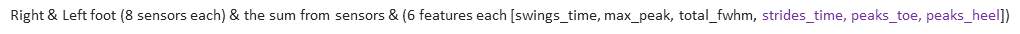

In [45]:
colnames_9=['r_interp','l_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_9.append( col +'_' +  x)

In [46]:
col_lists_9=[]
for col in ["l","r","L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_9.append( col +'_' +  x)

In [47]:
df_m_9 = data.scaled_stances_statics_df[colnames_9]
y_9 = data.scaled_stances_statics_df[[ 'level']]
y_9.replace(2, 1, inplace= True) 
y_9.replace(2.5, 2, inplace= True)  
y_m=y_9.astype('int')

# reformatting
for col in col_lists_9:
  colnames_9.remove(col)
d = data.return_array_df_mul_lists(df_m_9,col_lists_9,colnames_9)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
#df_m_9[np.isnan(df_9)] = 0
# splitting the data
X_train_m_9, X_test_m_9, y_train_m_9, y_test_m_9 = train_test_split(d, y_m, random_state=42)
X_train_m_9[np.isnan(X_train_m_9)] = 0
X_test_m_9[np.isnan(X_test_m_9)] = 0

<ipython-input-47-39d8bcbf3df4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-47-39d8bcbf3df4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
d.shape

(18226, 1828)

In [ ]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs_m=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_9, y_train_9, X_test_9,  y_test_9)

Estimator = 5
Accuracy: 0.8811, Precision: 0.8811, Recall: 0.8811, F1: 0.8811
Estimator = 10
Accuracy: 0.9085, Precision: 0.9085, Recall: 0.9085, F1: 0.9085
Estimator = 20
Accuracy: 0.9219, Precision: 0.9219, Recall: 0.9219, F1: 0.9219
Estimator = 40
Accuracy: 0.9344, Precision: 0.9344, Recall: 0.9344, F1: 0.9344
Estimator = 100
Accuracy: 0.9399, Precision: 0.9399, Recall: 0.9399, F1: 0.9399
Estimator = 200
Accuracy: 0.9397, Precision: 0.9397, Recall: 0.9397, F1: 0.9397


In [49]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
d[np.isnan(d)] = 0
cross_val_multiple_scores(rfc, d, y_m,10,'macro')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packa

Test Accuracy: 0.5247694870941072 +/- 0.25382070969281484
Test Prec: 0.5567212820097145 +/- 0.2626614813657373
Test Recall: 0.45775134659130395 +/- 0.27889939865702795
Test F1: 0.4643250098424446 +/- 0.2958831695484759


[0.5247694870941072,
 0.5567212820097145,
 0.45775134659130395,
 0.4643250098424446]

### 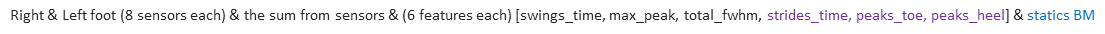

In [50]:
colnames_8=['r_interp','r_swings_time','r_max_peak','r_total_fwhm','r_strides_time','r_peaks_toe','r_peaks_heel','l_interp','l_swings_time','l_max_peak','l_total_fwhm','l_strides_time','l_peaks_toe','l_peaks_heel']
for col in ["L1",	"L2",	"L3"	,"L4",	"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp", "fwhm"]:
      colnames_8.append( col +'_' +  x)

for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8",	"Total_Force_Left",	"Total_Force_Right"]:
    for x in ["Min", "Max", "Std", "Med", "Avg", "Skewness","Kurtosis"]:
      colnames_8.append( col +'_' +  x)
  
col_lists_8=['r_interp','l_interp']
for col in ["L1",	"L2",	"L3"	,"L4"	,"L5",	"L6",	"L7"	,"L8",	"R1",	"R2"	,"R3",	"R4",	"R5",	"R6",	"R7",	"R8"]:
    for x in ["interp"]:
      col_lists_8.append( col +'_' +  x)

df_8 = data.scaled_stances_statics_df[colnames_8]
y_8 = data.scaled_stances_statics_df[[ 'level']]
y_8.replace(3, 4, inplace= True) 
y_8.replace(2.5, 3, inplace= True)  
y_m=y_8.astype('int')
# reformatting
for col in col_lists_8:
  colnames_8.remove(col)
df_8 = data.return_array_df_mul_lists(df_8,col_lists_8,colnames_8)
# df_7 = np.asarray([l for l in df_7 if ~np.isnan(l).any()])
df_8[np.isnan(df_8)] = 0
# splitting the data
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(df_8, y_m, random_state=42)


<ipython-input-50-e35e699b1e90>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-50-e35e699b1e90>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train_8[np.isnan(X_train_8)] = 0
X_test_8[np.isnan(X_test_8)] = 0

In [ ]:
# Checking which RFC will work the best
rfc_m = RFClassifier(models_path,200,2,'micro')
ccs_m=rfc_m.multiple_training([5, 10, 20, 40, 100, 200],2, X_train_8, y_train_8, X_test_8,  y_test_8)

Estimator = 5
Accuracy: 0.9991, Precision: 0.9991, Recall: 0.9991, F1: 0.9991
Estimator = 10
Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1: 0.9998
Estimator = 20
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 40
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 100
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Estimator = 200
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [52]:
rfc = RandomForestClassifier(n_estimators= int(100), n_jobs= 2,random_state=42)
#d[np.isnan(d)] = 0
cross_val_multiple_scores(rfc, df_8, np.ravel(y_m),10,'macro')

Test Accuracy: 0.7434535719640427 +/- 0.18305388597872466
Test Prec: 0.8086953999844203 +/- 0.1571548561447196
Test Recall: 0.7563560806441758 +/- 0.23641769698294218
Test F1: 0.7538302740841789 +/- 0.24374107045784124


[0.7434535719640427,
 0.8086953999844203,
 0.7563560806441758,
 0.7538302740841789]

### Cross Verification

In [ ]:
scores = cross_val_search(X_train_m, np.ravel(y_train_m),X_test_m, np.ravel(y_test_m),'macro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 0.8157894736842105
Test Prec: 0.8102918586789555
Test Recall: 0.7968344456803855
Test F1: 0.8021505376344086
{'n_estimators': 100}


In [ ]:
scores = cross_val_search(X_train_m, np.ravel(y_train_m),X_test_m, np.ravel(y_test_m),'micro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 0.8289473684210527
Test Prec: 0.8289473684210527
Test Recall: 0.8289473684210527
Test F1: 0.8289473684210527
{'n_estimators': 50}


In [ ]:
scores = cross_val_search(X_train_m_9, np.ravel(y_train_m_9),X_test_m_9, np.ravel(y_test_m_9),'micro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 0.9400921658986175
Test Prec: 0.9400921658986175
Test Recall: 0.9400921658986175
Test F1: 0.9400921658986175
{'n_estimators': 200}


In [ ]:
scores = cross_val_search(X_train_m_9, np.ravel(y_train_m_9),X_test_m_9, np.ravel(y_test_m_9),'macro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 0.9400921658986175
Test Prec: 0.9426319752594219
Test Recall: 0.9167567952064145
Test F1: 0.9283000569586638
{'n_estimators': 200}


In [ ]:
scores = cross_val_search(X_train_8, np.ravel(y_train_8),X_test_8, np.ravel(y_test_8),'micro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 1.0
Test Prec: 1.0
Test Recall: 1.0
Test F1: 1.0
{'n_estimators': 50}


In [ ]:
scores = cross_val_search(X_train_8, np.ravel(y_train_8),X_test_8, np.ravel(y_test_8),'macro')
cross_scores_search_multi['acc'].append(scores[0])
cross_scores_search_multi['prec'].append(scores[1])
cross_scores_search_multi['rec'].append(scores[2])
cross_scores_search_multi['f1'].append(scores[3])

Test Accuracy: 1.0
Test Prec: 1.0
Test Recall: 1.0
Test F1: 1.0
{'n_estimators': 50}


In [ ]:
cross_scores_search_multi['acc']=[0.8157894736842105,0.9400921658986175,1]
cross_scores_search_multi['prec']=[0.8102918586789555,0.9426319752594219,1]
cross_scores_search_multi['rec']=[0.7968344456803855,0.9167567952064145,1]
cross_scores_search_multi['f1']=[0.8021505376344086,0.9283000569586638,1]

In [ ]:
labels = ['Baseline model',\
          'Multidim signals & Accum <br> signal & features',\
          'Multidim signals & Accum <br> signal & features & BLM statics']
pd.options.plotting.backend = "plotly"
df = pd.DataFrame({ 'Label' : labels,\
                   'Accuracy' :cross_scores_search_multi['acc'],
                   'Precision': cross_scores_search_multi['prec'],
                   'Recall':cross_scores_search_multi['rec'],
                   'F1':cross_scores_search_multi['f1']})
df.plot(x='Label', y=df.columns[1:],
        labels={
                     "Label": "Input Data",
                     "variable": "Metric"
                 },
                title="Severity Detection models")

In [ ]:
df.to_parquet(parquet_path+'rfc_severity_metrics.gzip')

In [ ]:
df

,Label,Accuracy,Precision,Recall,F1
0,Baseline model,0.815789,0.810292,0.796834,0.802151
1,Multidim signals & Accum <br> signal & features,0.940092,0.942632,0.916757,0.928300
2,Multidim signals & Accum <br> signal & feature...,1.000000,1.000000,1.000000,1.000000


In [56]:
labels = ['Baseline model',\
          'Multidim signals & Accum <br> signal & features',\
          'Multidim signals & Accum <br> signal & features & BLM statics']
pd.options.plotting.backend = "plotly"
df = pd.DataFrame({ 'Label' : labels,\
                   'Accuracy' :[0.7163,0.5248,0.7435],
                   'Precision':[0.6810,0.5568,0.8087],
                   'Recall':[0.6658,0.4578,0.7564],
                   'F1':[0.6580,0.4643,0.7538]})
df.plot(x='Label', y=df.columns[1:],
        labels={
                     "Label": "Input Data",
                     "variable": "Metric"
                 },
                title="Severity Detection models")